In [1]:
import kagglehub
import os
import shutil

import sys
from pathlib import Path

dataset_id = "uciml/red-wine-quality-cortez-et-al-2009"
local_dataset_name = dataset_id.split('/')[-1] # Uses the last part of the ID


base_data_dir = Path("/home/jovyan/data") # Standard for jovyan user
# base_data_dir = project_root / "data" # Alternative for local non-Docker runs
dataset_specific_base_path = base_data_dir / local_dataset_name
raw_data_target_dir = dataset_specific_base_path / "raw"
print(f"Target dataset base path: {dataset_specific_base_path}")

# expected_raw_file_name = "winequality-red.csv"
# final_raw_file_path = raw_data_target_dir / expected_raw_file_name
# print(f"Target raw data file: {final_raw_file_path}")

# Check if dataset already exists in destination
destination_path = f"/home/jovyan/data/{local_dataset_name}"
if os.path.exists(raw_data_target_dir) and os.listdir(dataset_specific_base_path):
    print(f"Raw dataset already exists at {raw_data_target_dir}")
    print("Skipping download...")
else:
    print(f"Dataset not found locally. Downloading {dataset_id}...")
    download_path = kagglehub.dataset_download(dataset_id)
    print(f"Dataset downloaded to temporary path in container: {download_path}")
    print(f"Copying dataset to persistent raw data volume: {raw_data_target_dir}")
    # Ensure the destination directory exists 
    os.makedirs(raw_data_target_dir, exist_ok=True)
    for item in os.listdir(download_path):
        s = os.path.join(download_path, item)
        d = os.path.join(raw_data_target_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

    print(f"Dataset '{dataset_id}' successfully copied to {raw_data_target_dir} in shared volume.")
print(f"Raw dataset saved to persistent volume at: {raw_data_target_dir}")


Target dataset base path: /home/jovyan/data/red-wine-quality-cortez-et-al-2009
Raw dataset already exists at /home/jovyan/data/red-wine-quality-cortez-et-al-2009/raw
Skipping download...
Raw dataset saved to persistent volume at: /home/jovyan/data/red-wine-quality-cortez-et-al-2009/raw


In [2]:
# --- Cell 2: Import Libraries and Load Data ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
import cProfile # For basic profiling
import pstats # For processing profiling results
import io # For capturing profiling output

print(f"Listing files in {raw_data_target_dir}:")
try:
    for root, dirs, files in os.walk(raw_data_target_dir):
        level = root.replace(str(raw_data_target_dir), '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
except FileNotFoundError:
    print(f"Error: Directory not found: {raw_data_target_dir}. Please ensure the dataset was downloaded and copied correctly.")
    # Exit or handle the error appropriately if the directory is not found

csv_files = [f for f in os.listdir(raw_data_target_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError(f"No CSV files found in {raw_data_target_dir}")
if len(csv_files) > 1:
    print(f"Warning: Multiple CSV files found. Using the first one: {csv_files[0]}")

# Load the data
data_file_path = os.path.join(raw_data_target_dir, csv_files[0])
print(f"\nLoading data from: {data_file_path}")
df = pd.read_csv(data_file_path)

print("\nAvailable columns in the RAW dataset:")
for i, col in enumerate(df.columns):
    print(f"{i}: {col}")



Listing files in /home/jovyan/data/red-wine-quality-cortez-et-al-2009/raw:
raw/
    winequality-red.csv

Loading data from: /home/jovyan/data/red-wine-quality-cortez-et-al-2009/raw/winequality-red.csv

Available columns in the RAW dataset:
0: fixed acidity
1: volatile acidity
2: citric acid
3: residual sugar
4: chlorides
5: free sulfur dioxide
6: total sulfur dioxide
7: density
8: pH
9: sulphates
10: alcohol
11: quality


In [3]:

sys.path.append(str(Path().resolve().parent))

from utils.etl import run_default_etl
import numpy as np
# import inspect
target_column = "quality"
# etl_result = run_default_etl(dataset_name=local_dataset_name, target_column=target_column)
etl_result = run_custom_etl(dataset_name=local_dataset_name, target_column=target_column)

X_train = etl_result["X_train"]
y_train = etl_result["y_train"]
X_val = etl_result["X_val"]
y_val = etl_result["y_val"]

# === Task Type Inference ===
num_classes = y_train.nunique()
target_dtype = y_train.dtype

print(f"🧠 Target column: {target_column}")
print(f"📊 Target dtype: {target_dtype}")
print(f"🔢 Unique classes: {num_classes}")
print(f"🟨 Sample labels: {y_train.unique()[:5].tolist()}")

if np.issubdtype(target_dtype, np.floating):
    task_type = "regression"
elif num_classes <= 2:
    task_type = "binary_classification"
elif num_classes > 2:
    task_type = "multiclass_classification"
else:
    raise ValueError("Unable to determine task type from target data")

print(f"✅ Inferred task type: {task_type}")


[PosixPath('/home/jovyan/data/red-wine-quality-cortez-et-al-2009/raw/winequality-red.csv')]
Dataset loaded successfully. Only one file loaded
Dataset shape: (1599, 12)
Dataset columns: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Dataset head:
    fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   


ETL Version: v11
ETL Description: Default ETL logic
📊 Target Column Summary:
  Shape: (1279,)
  Unique values: [6, 5, 4, 7, 8, 3]
  Value counts:


quality
3      9
4     43
5    551
6    506
7    157
8     13
Name: count, dtype: int64

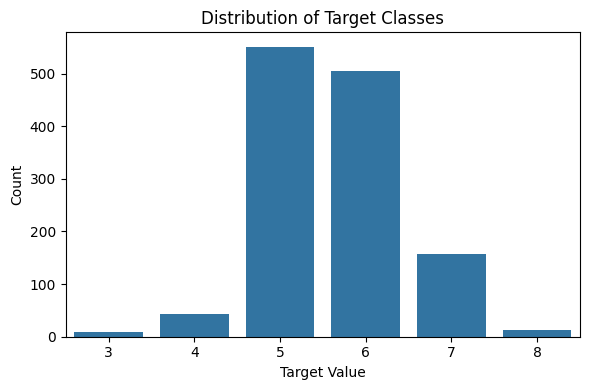

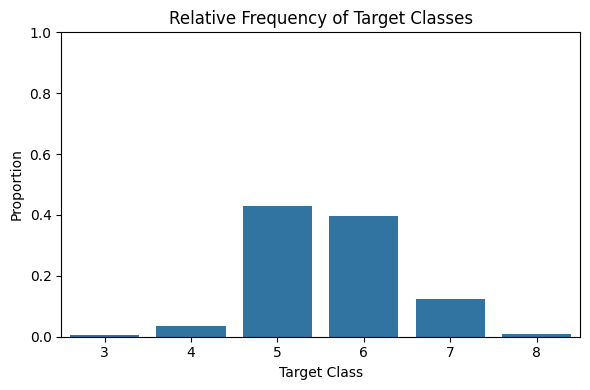

🔍 Feature distributions grouped by target class:


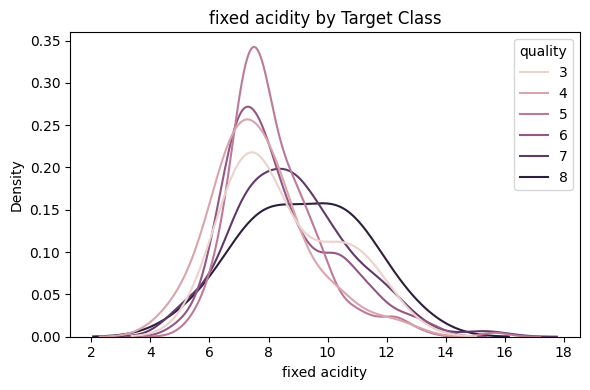

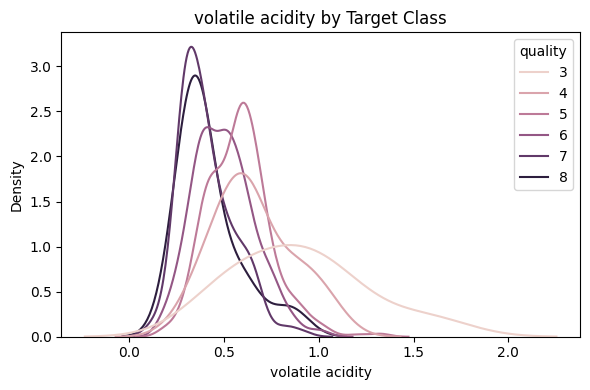

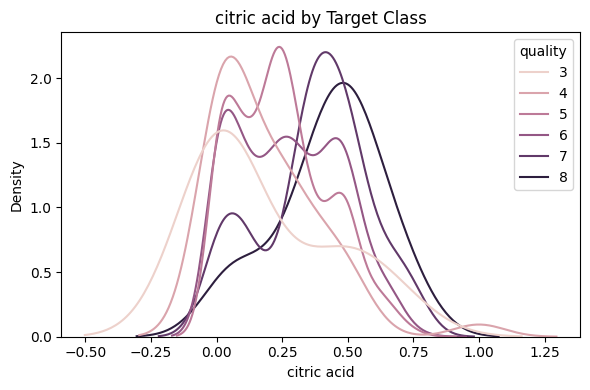

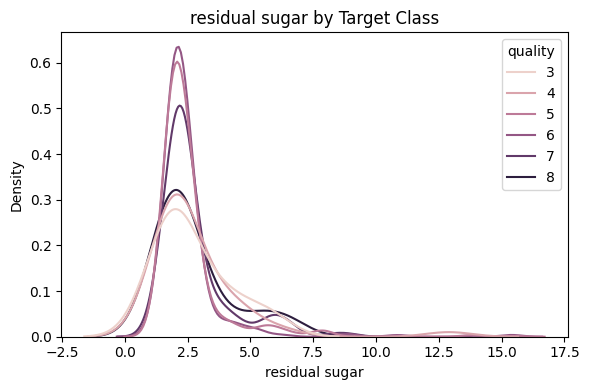

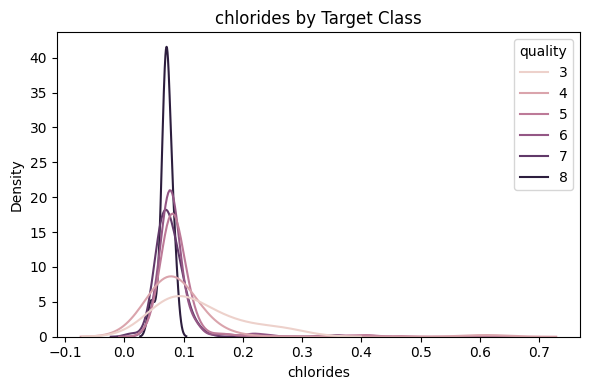

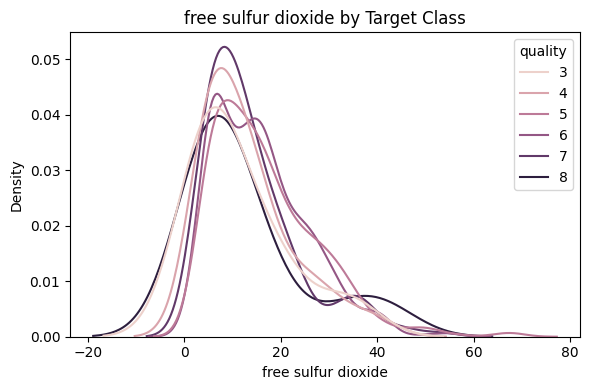

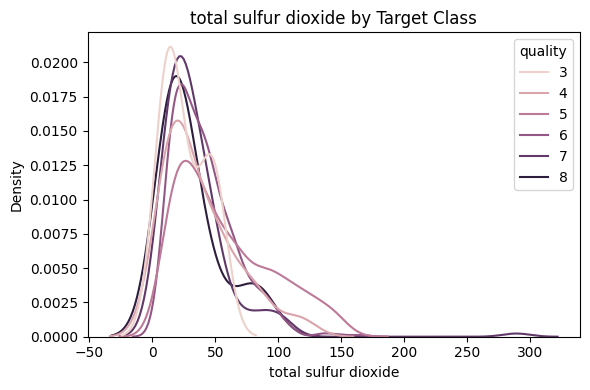

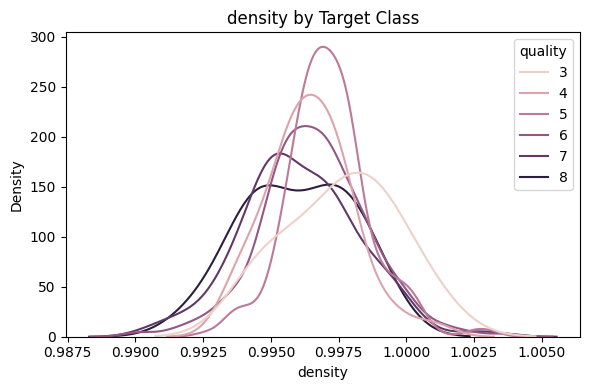

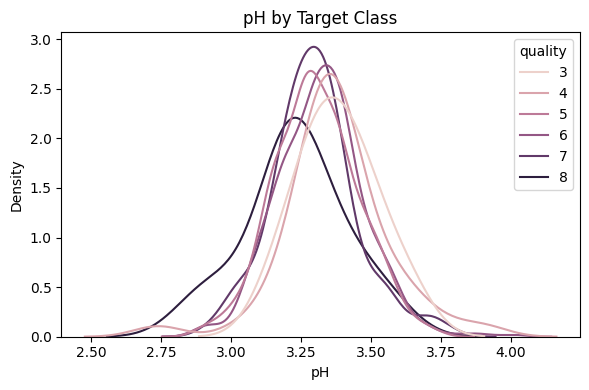

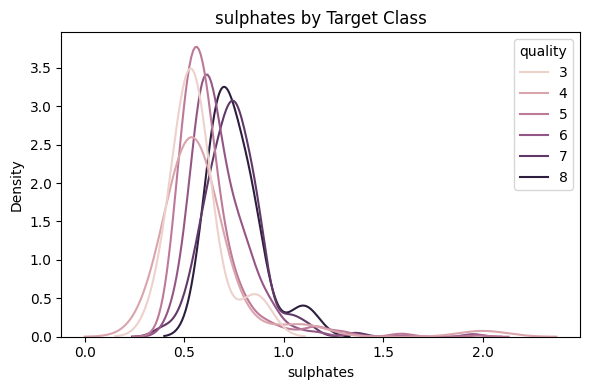

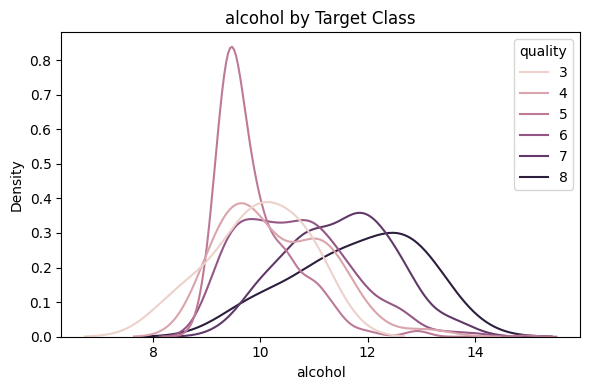

In [6]:
# === Exploratory Data Analysis y Target ===
import seaborn as sns
import matplotlib.pyplot as plt

print(f"ETL Version: {etl_result['etl_version']}")
print(f"ETL Description: {etl_result['etl_description']}")

print("📊 Target Column Summary:")
print(f"  Shape: {y_train.shape}")
print(f"  Unique values: {y_train.unique().tolist()}")
print(f"  Value counts:")
display(y_train.value_counts().sort_index())

# === Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train, order=sorted(y_train.unique()))
plt.title("Distribution of Target Classes")
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# === Relative Frequency Bar Plot ===
value_counts = y_train.value_counts(normalize=True).sort_index()

plt.figure(figsize=(6, 4))
sns.barplot(x=value_counts.index, y=value_counts.values)
plt.title("Relative Frequency of Target Classes")
plt.ylabel("Proportion")
plt.xlabel("Target Class")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

if task_type in ["binary_classification", "multiclass_classification"]:
    print("🔍 Feature distributions grouped by target class:")
    for col in X_train.columns:
        plt.figure(figsize=(6, 4))
        sns.kdeplot(data=X_train, x=col, hue=y_train, common_norm=False)
        plt.title(f"{col} by Target Class")
        plt.tight_layout()
        plt.show()


ETL Version: v11
ETL Description: Default ETL logic
X_train shape: (1279, 11), y_train shape: (1279,)
X_val shape: (320, 11), y_val shape: (320,)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000,1279.000000
mean,8.323690,0.530559,0.272471,2.555473,0.088448,15.876075,46.657154,0.996774,3.311650,0.660023,10.418100
std,1.724243,0.179275,0.195448,1.435790,0.049332,10.313517,32.941962,0.001856,0.154016,0.174605,1.052694
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.370000,8.400000
25%,7.100000,0.400000,0.100000,1.900000,0.071000,7.000000,22.000000,0.995655,3.210000,0.550000,9.500000
50%,7.900000,0.520000,0.260000,2.200000,0.080000,14.000000,38.000000,0.996800,3.310000,0.620000,10.200000
75%,9.200000,0.640000,0.430000,2.600000,0.091000,21.000000,63.000000,0.997845,3.400000,0.730000,11.100000
max,15.900000,1.580000,1.000000,15.500000,0.611000,68.000000,289.000000,1.003690,4.010000,2.000000,14.900000


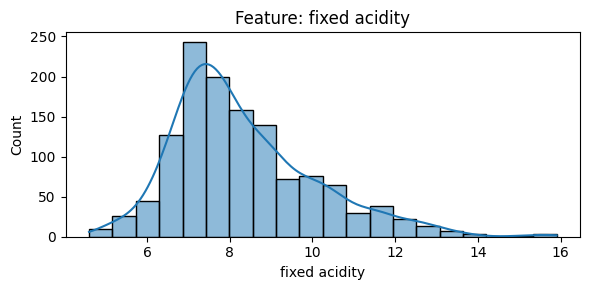

📈 fixed acidity Stats:
  Mean: 8.324
  Std: 1.724
  Skewness: 0.963
  Kurtosis: 1.088
  Correlation with target: 0.122
  Most correlated with: pH (-0.676)
🔧 Suggested preprocessing: ✅ None



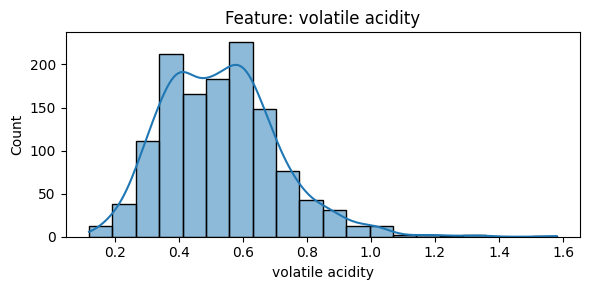

📈 volatile acidity Stats:
  Mean: 0.531
  Std: 0.179
  Skewness: 0.744
  Kurtosis: 1.497
  Correlation with target: -0.378
  Most correlated with: citric acid (-0.545)
🔧 Suggested preprocessing: ✅ None



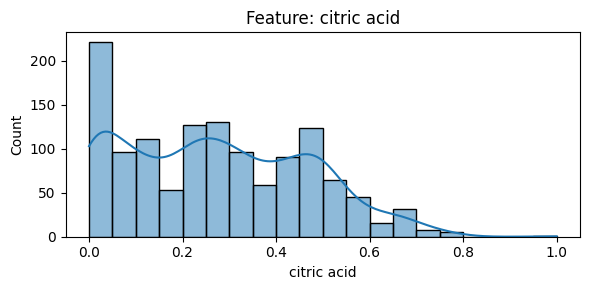

📈 citric acid Stats:
  Mean: 0.272
  Std: 0.195
  Skewness: 0.314
  Kurtosis: -0.783
  Correlation with target: 0.216
  Most correlated with: fixed acidity (0.669)
🔧 Suggested preprocessing: ✅ None



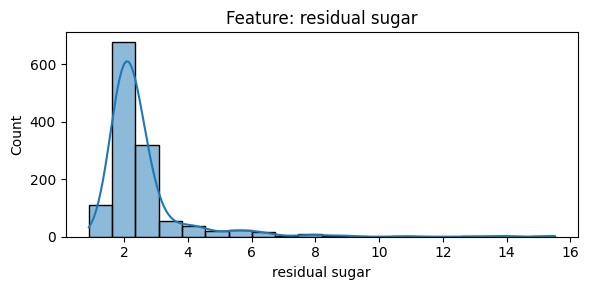

📈 residual sugar Stats:
  Mean: 2.555
  Std: 1.436
  Skewness: 4.559
  Kurtosis: 28.918
  Correlation with target: 0.005
  Most correlated with: density (0.377)
🔧 Suggested preprocessing: 🌀 Transform (non-Gaussian) | 🤔 Low correlation with target



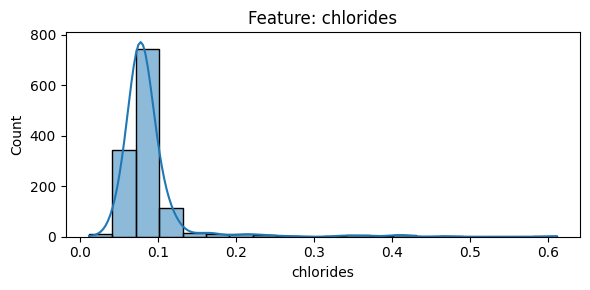

📈 chlorides Stats:
  Mean: 0.088
  Std: 0.049
  Skewness: 5.565
  Kurtosis: 39.365
  Correlation with target: -0.127
  Most correlated with: sulphates (0.382)
🔧 Suggested preprocessing: 🌀 Transform (non-Gaussian)



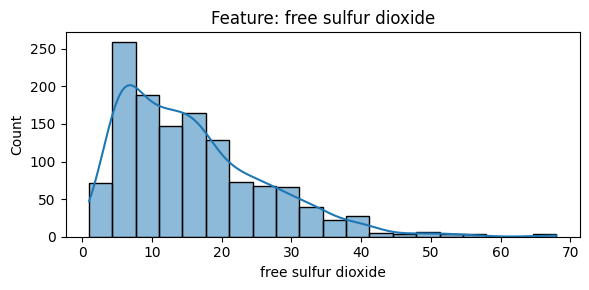

📈 free sulfur dioxide Stats:
  Mean: 15.876
  Std: 10.314
  Skewness: 1.197
  Kurtosis: 1.816
  Correlation with target: -0.056
  Most correlated with: total sulfur dioxide (0.668)
🔧 Suggested preprocessing: 🌀 Transform (non-Gaussian)



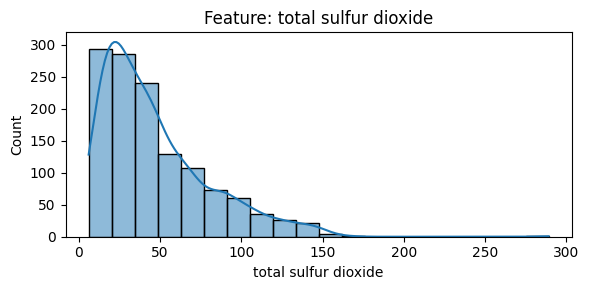

📈 total sulfur dioxide Stats:
  Mean: 46.657
  Std: 32.942
  Skewness: 1.384
  Kurtosis: 2.756
  Correlation with target: -0.200
  Most correlated with: free sulfur dioxide (0.668)
🔧 Suggested preprocessing: 🔄 Normalize (high range) | 🌀 Transform (non-Gaussian)



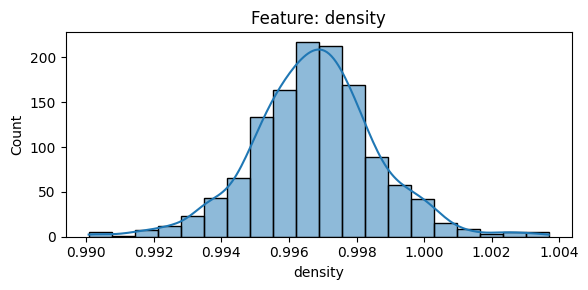

📈 density Stats:
  Mean: 0.997
  Std: 0.002
  Skewness: 0.056
  Kurtosis: 1.080
  Correlation with target: -0.167
  Most correlated with: fixed acidity (0.661)
🔧 Suggested preprocessing: ✅ None



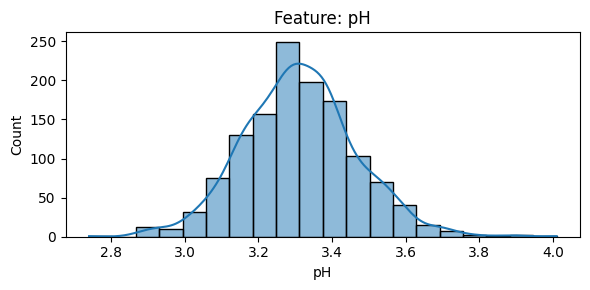

📈 pH Stats:
  Mean: 3.312
  Std: 0.154
  Skewness: 0.198
  Kurtosis: 0.713
  Correlation with target: -0.045
  Most correlated with: fixed acidity (-0.676)
🔧 Suggested preprocessing: 🤔 Low correlation with target



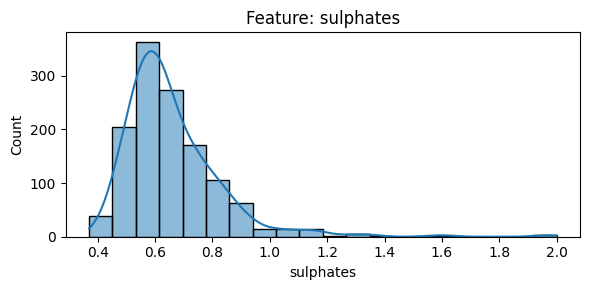

📈 sulphates Stats:
  Mean: 0.660
  Std: 0.175
  Skewness: 2.589
  Kurtosis: 12.561
  Correlation with target: 0.243
  Most correlated with: chlorides (0.382)
🔧 Suggested preprocessing: 🌀 Transform (non-Gaussian)



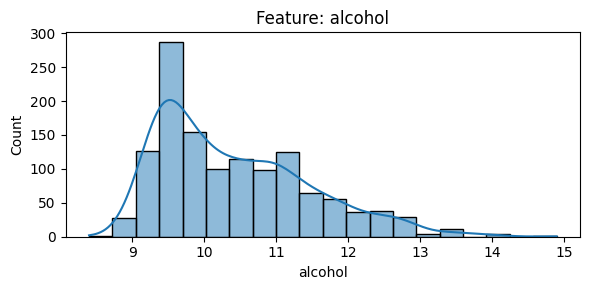

📈 alcohol Stats:
  Mean: 10.418
  Std: 1.053
  Skewness: 0.865
  Kurtosis: 0.236
  Correlation with target: 0.473
  Most correlated with: density (-0.480)
🔧 Suggested preprocessing: ✅ None



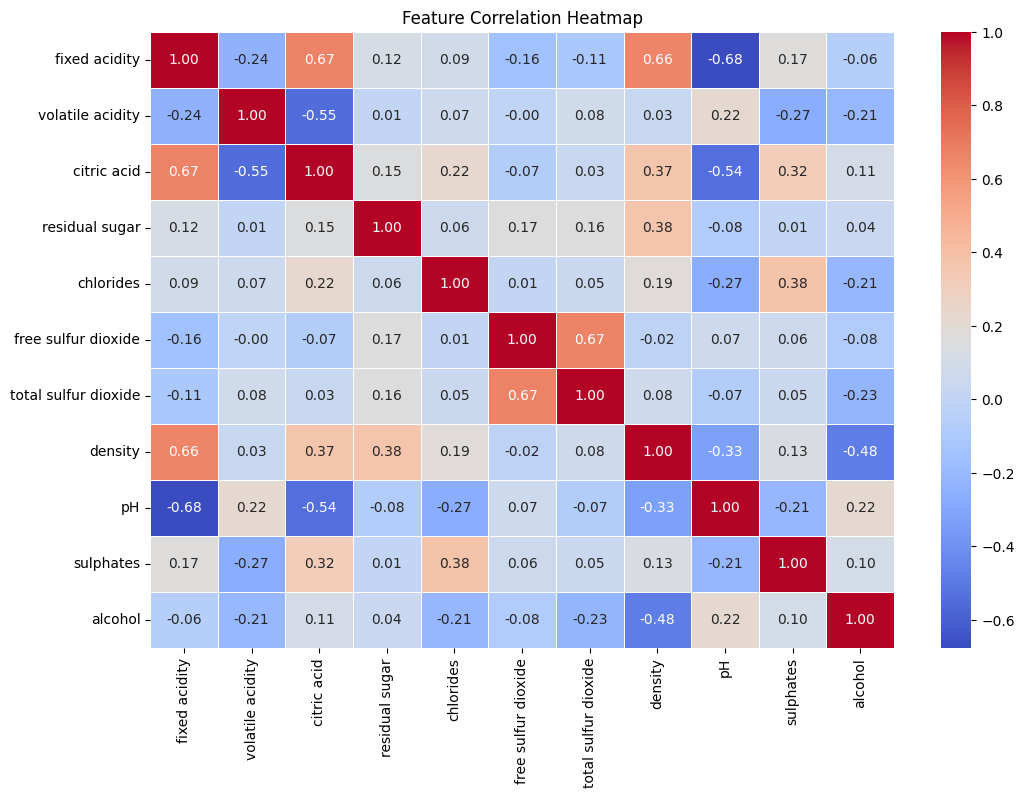

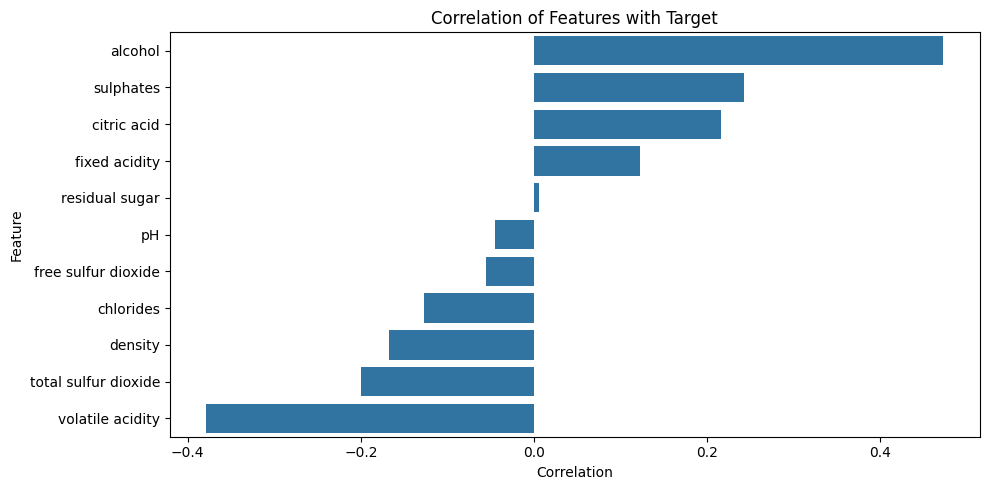

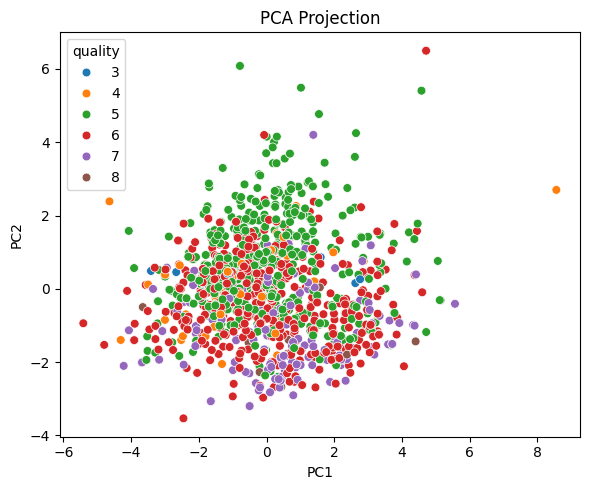

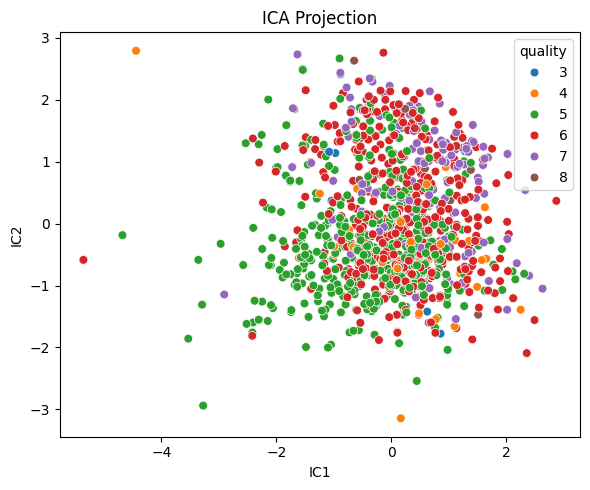

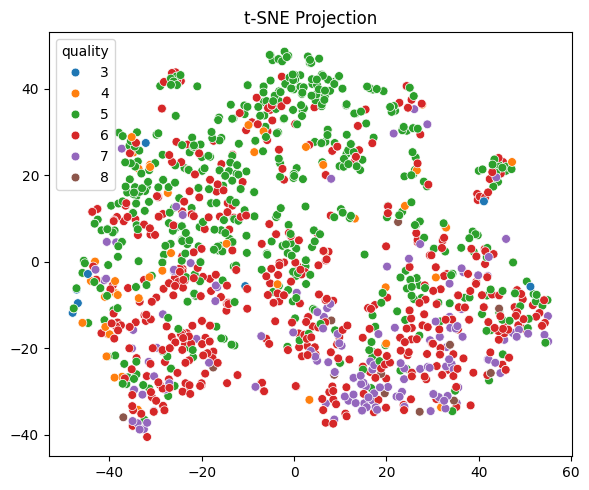

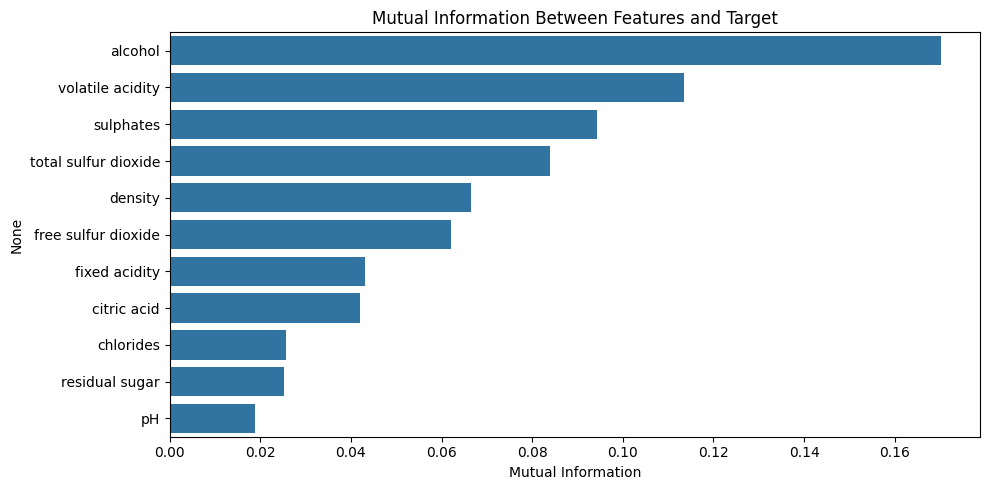

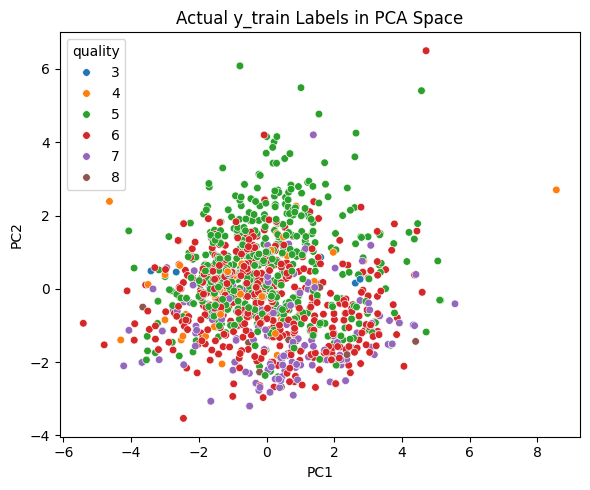

🔍 KMeans Target Distribution per Cluster


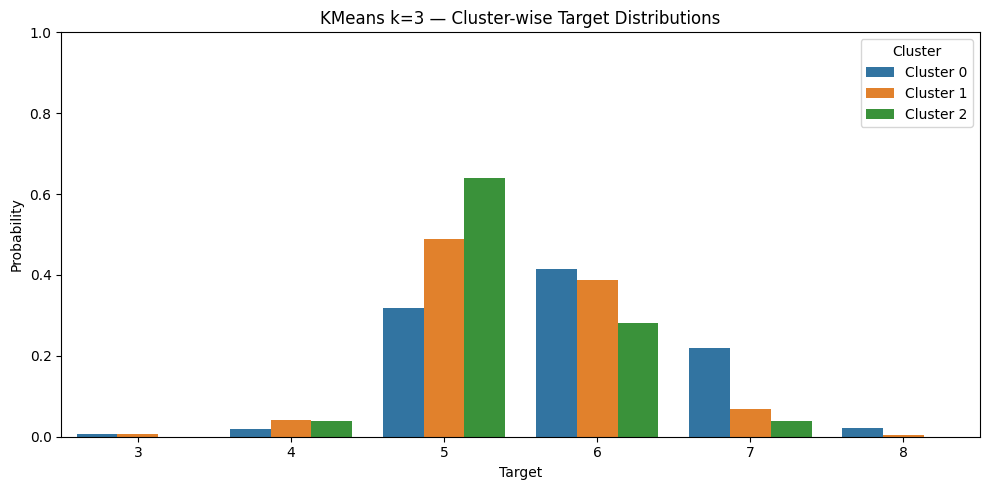

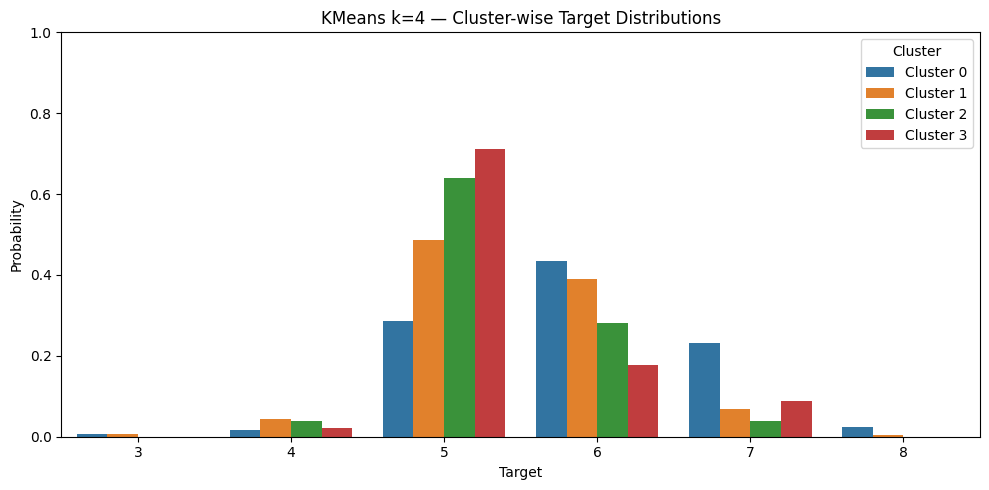

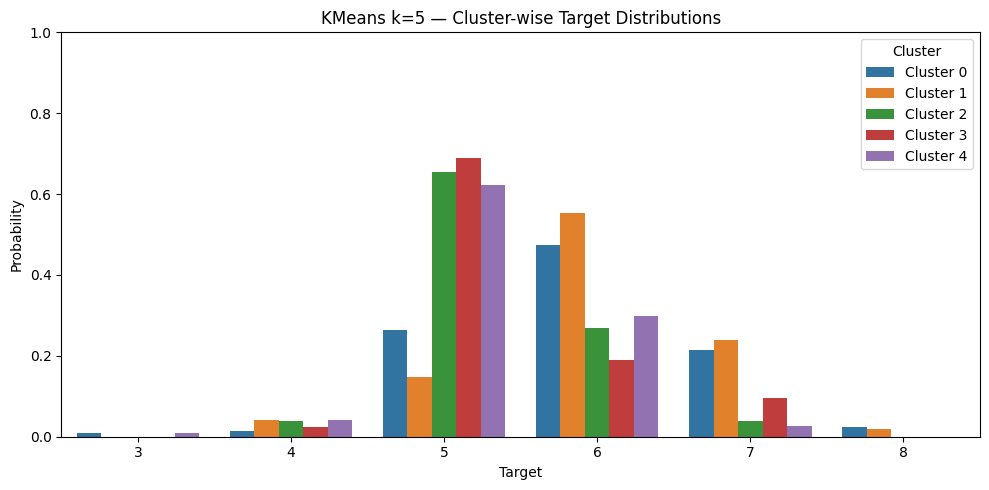

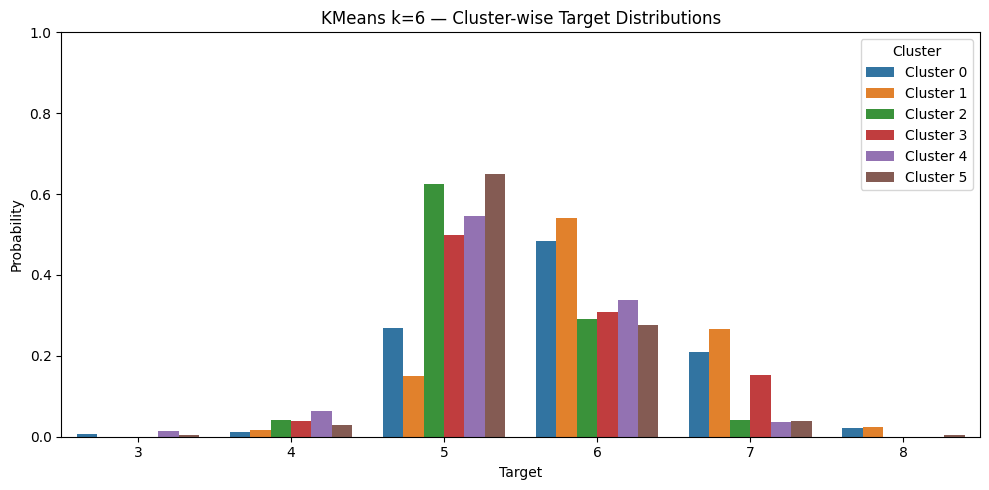

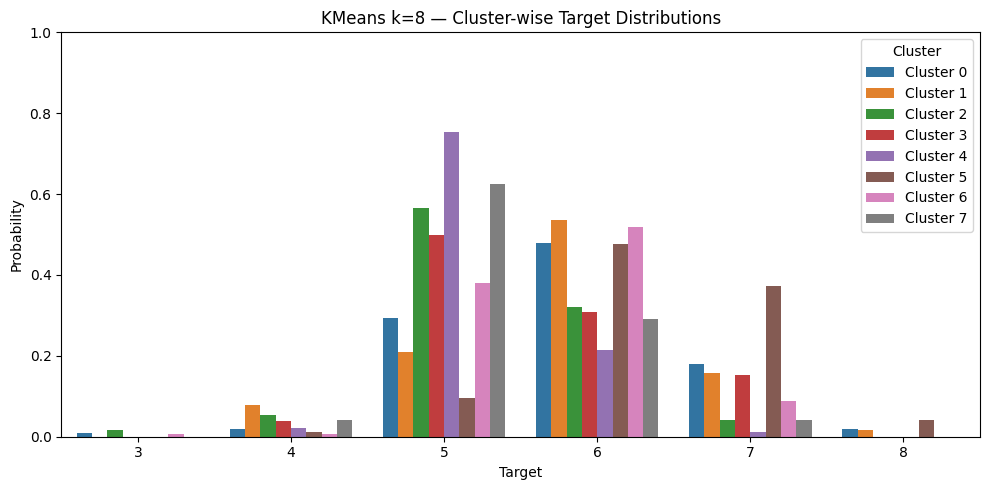

🔍 GMM Target Distribution per Cluster


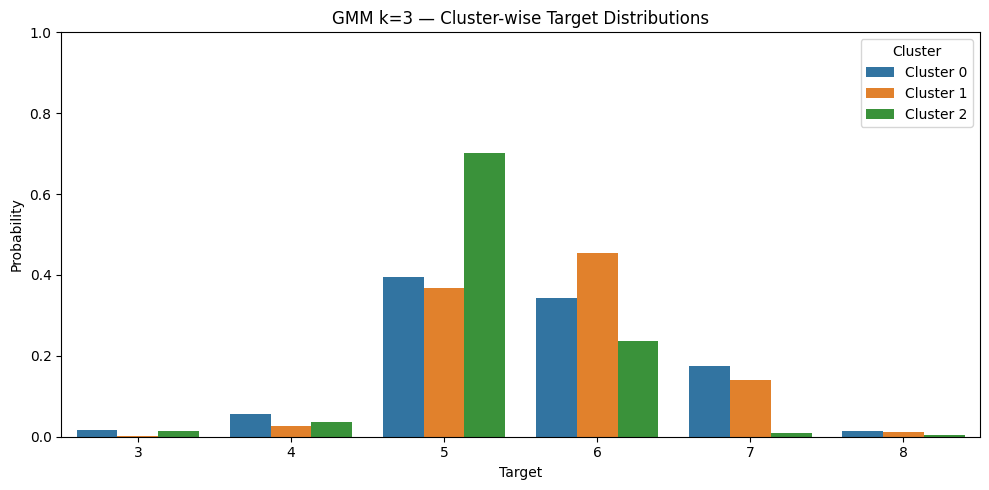

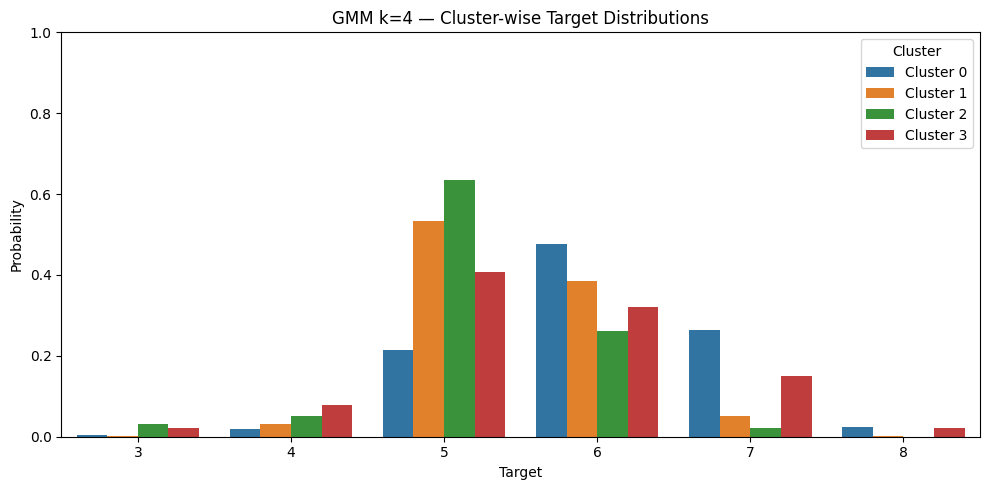

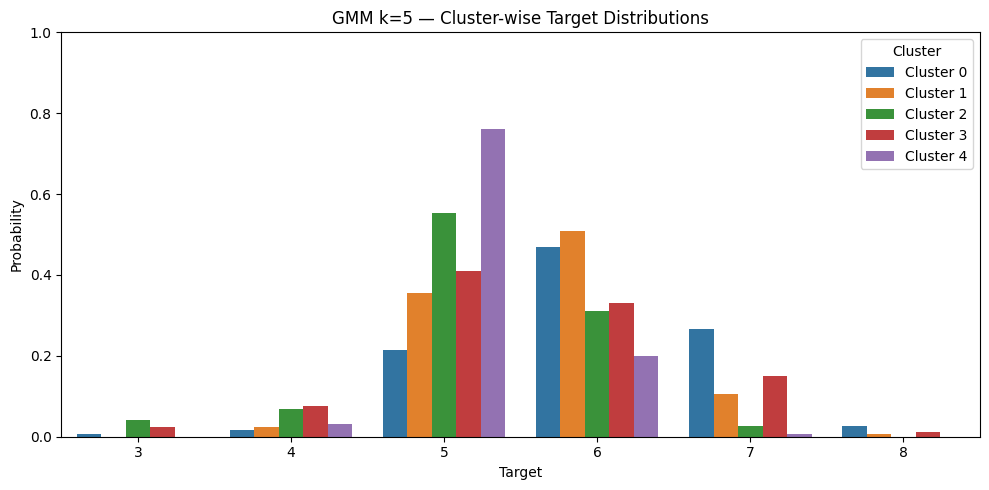

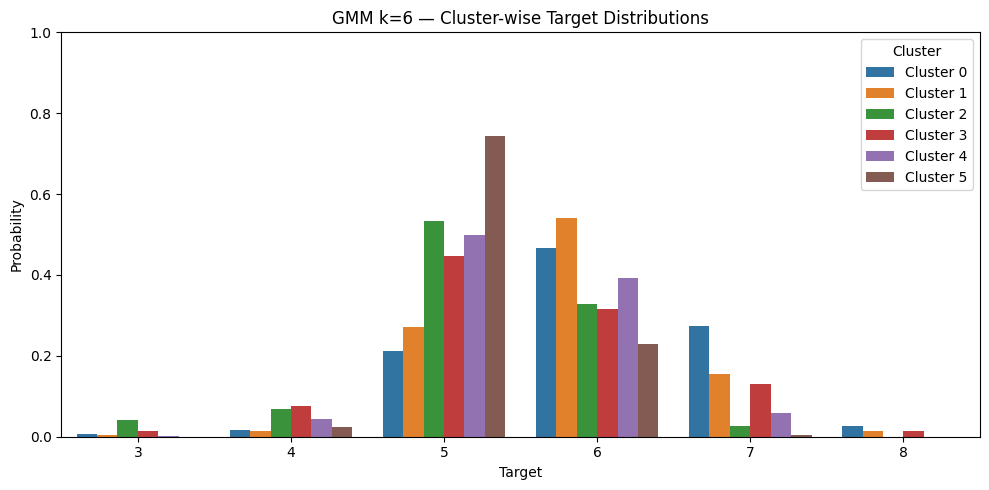

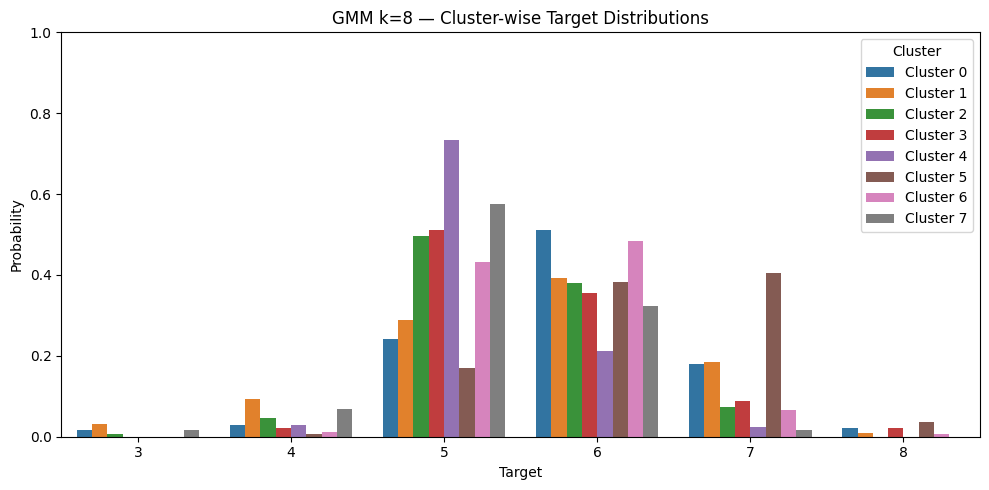

In [7]:
# === Exploratory Data Analysis X features ===

print(f"ETL Version: {etl_result['etl_version']}")
print(f"ETL Description: {etl_result['etl_description']}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np


# === Summary Statistics ===
display(X_train.describe())

# === Feature Diagnostics ===
for col in X_train.columns:
    feature = X_train[col]
    
    plt.figure(figsize=(6, 3))
    sns.histplot(feature, kde=True, bins=20)
    plt.title(f"Feature: {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

    mean = feature.mean()
    std = feature.std()
    skewness = skew(feature)
    kurt = kurtosis(feature)
    min_val, max_val = feature.min(), feature.max()
    zero_variance = np.isclose(std, 0.0)

    # Correlation with target
    try:
        target_corr = np.corrcoef(feature, y_train)[0, 1]
    except Exception:
        target_corr = float('nan')

    # Max correlation with other features
    corr_with_others = X_train.corr()[col].drop(col)
    most_corr_feat = corr_with_others.abs().idxmax()
    most_corr_val = corr_with_others[most_corr_feat]

    # === Preprocessing Suggestions ===
    suggestions = []

    if zero_variance:
        suggestions.append("🔻 Drop (zero variance)")
    elif std > 50 or abs(mean) > 100 or max_val - min_val > 100:
        suggestions.append("🔄 Normalize (high range)")
    if abs(skewness) > 1 or abs(kurt) > 3:
        suggestions.append("🌀 Transform (non-Gaussian)")
    if feature.dtype == "object" or feature.nunique() < 10:
        suggestions.append("📦 Encode (categorical or discrete)")
    if abs(target_corr) < 0.05:
        suggestions.append("🤔 Low correlation with target")

    print(f"📈 {col} Stats:")
    print(f"  Mean: {mean:.3f}")
    print(f"  Std: {std:.3f}")
    print(f"  Skewness: {skewness:.3f}")
    print(f"  Kurtosis: {kurt:.3f}")
    print(f"  Correlation with target: {target_corr:.3f}")
    print(f"  Most correlated with: {most_corr_feat} ({most_corr_val:.3f})")

    print(f"🔧 Suggested preprocessing: {' | '.join(suggestions) if suggestions else '✅ None'}")
    print()

# === Feature Correlation Matrix ===
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# === Correlation with Target ===
Xy_corr = X_train.copy()
Xy_corr["target"] = y_train
target_corr = Xy_corr.corr()["target"].drop("target").sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title("Correlation of Features with Target")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# === Standardize for PCA, ICA, t-SNE ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# === PCA ===
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1], hue=y_train, palette='tab10', s=40)
plt.title("PCA Projection")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# === ICA ===
ica = FastICA(n_components=2, random_state=42)
ica_proj = ica.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=ica_proj[:, 0], y=ica_proj[:, 1], hue=y_train, palette='tab10', s=40)
plt.title("ICA Projection")
plt.xlabel("IC1")
plt.ylabel("IC2")
plt.tight_layout()
plt.show()

# === t-SNE ===
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_proj = tsne.fit_transform(X_scaled)

plt.figure(figsize=(6, 5))
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=y_train, palette='tab10', s=40)
plt.title("t-SNE Projection")
plt.tight_layout()
plt.show()

# === Feature Interdependency via Mutual Information ===
if task_type == "regression":
    mi = mutual_info_regression(X_train, y_train)
else:
    mi = mutual_info_classif(X_train, y_train)

mi_series = pd.Series(mi, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x=mi_series.values, y=mi_series.index)
plt.title("Mutual Information Between Features and Target")
plt.xlabel("Mutual Information")
plt.tight_layout()
plt.show()


# === PCA for visualization space (2D) ===
pca_vis = PCA(n_components=2, random_state=42)
X_vis = pca_vis.fit_transform(X_scaled)


# === Plot True Labels for Comparison ===
plt.figure(figsize=(6, 5))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y_train, palette='tab10', s=30)
plt.title("Actual y_train Labels in PCA Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# === Define cluster counts to try ===
cluster_counts = [3, 4,5,6,8]

def plot_cluster_class_distribution(y_true, cluster_labels, k, method_name=""):
    """
    For each cluster, show the distribution of target classes (y_true)
    as grouped bars on a single plot.
    """
    df = pd.DataFrame({
        "cluster": cluster_labels,
        "target": y_true
    })

    cluster_ids = sorted(df["cluster"].unique())
    target_classes = sorted(df["target"].unique())

    # Compute distribution: P(y | cluster)
    data = []
    for cluster_id in cluster_ids:
        subset = df[df["cluster"] == cluster_id]
        total = len(subset)
        dist = subset["target"].value_counts(normalize=True).reindex(target_classes, fill_value=0)
        for y_val, prob in dist.items():
            data.append({"Cluster": f"Cluster {cluster_id}", "Target": y_val, "Probability": prob})

    dist_df = pd.DataFrame(data)

    # Plot
    plt.figure(figsize=(10, 5))
    sns.barplot(data=dist_df, x="Target", y="Probability", hue="Cluster")
    plt.title(f"{method_name} k={k} — Cluster-wise Target Distributions")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

# KMeans
print("🔍 KMeans Target Distribution per Cluster")
for k in cluster_counts:
    km = KMeans(n_clusters=k, random_state=42)
    km_labels = km.fit_predict(X_scaled)
    plot_cluster_class_distribution(y_train, km_labels, k, method_name="KMeans")

# GMM
print("🔍 GMM Target Distribution per Cluster")
for k in cluster_counts:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=42)
    gmm_labels = gmm.fit_predict(X_scaled)
    plot_cluster_class_distribution(y_train, gmm_labels, k, method_name="GMM")


In [8]:
import sklearn.metrics

perf_eval_metric = "accuracy"  # or "accuracy", "precision", "recall", etc.

# Map of string -> (metric name, metric function)
metric_lookup = {
    "accuracy": ("accuracy", sklearn.metrics.accuracy_score),
    "f1": ("f1_score", lambda y_true, y_pred: sklearn.metrics.f1_score(y_true, y_pred, average="weighted")),
    "precision": ("precision", lambda y_true, y_pred: sklearn.metrics.precision_score(y_true, y_pred, average="weighted")),
    "recall": ("recall", lambda y_true, y_pred: sklearn.metrics.recall_score(y_true, y_pred, average="weighted")),
    "mse": ("mean_squared_error", sklearn.metrics.mean_squared_error),
    "mae": ("mean_absolute_error", sklearn.metrics.mean_absolute_error),
}

# Lookup the function and name
if perf_eval_metric not in metric_lookup:
    raise ValueError(f"Unsupported metric: {perf_eval_metric}")

eval_metric_name, eval_metric_fn = metric_lookup[perf_eval_metric]
print(f"✅ Evaluation metric set to: {eval_metric_name}")


✅ Evaluation metric set to: accuracy


In [9]:
from utils.models import get_sklearn_model, get_nn_model
from utils.train import train_sklearn_model, train_nn_model, log_model_artifact, log_final_metrics, evaluate_model, \
                        conditionally_encode_labels
import mlflow
os.environ["WANDB_BASE_URL"] = "http://wandb:8080"
os.environ["WANDB_DEBUG"] = "true"
os.environ["WANDB_DEBUG_LOG_PATH"] = "/tmp/wandb_debug.log"
import wandb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define model sweep
print("defining sweep")
model_configs = {
    "decision_tree": [
        {"criterion": c, "max_depth": d, "min_samples_split": m, "min_samples_leaf": l}
        for c in ["gini", "entropy"]
        for d in [None, 5, 10, 20]
        for m in [2, 5]
        for l in [1, 2]
    ],

    "random_forest": [
        {"n_estimators": n, "max_depth": d, "max_features": f, "min_samples_split": m}
        for n in [50, 100, 200]
        for d in [None, 10, 20]
        for f in ["sqrt", "log2"]
        for m in [2, 5]
    ],

    "logistic_regression": [
        {"penalty": p, "C": c, "solver": "liblinear", "max_iter": 200}
        for p in ["l1", "l2"]
        for c in [0.01, 0.1, 1.0, 10.0]
    ],

    "xgboost": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "subsample": s, "colsample_bytree": cbt}
        for n in [100, 200]
        for d in [3, 5, 7]
        for lr in [0.01, 0.1]
        for s in [0.8, 1.0]
        for cbt in [0.8, 1.0]
    ],

    "lightgbm": [
        {"n_estimators": n, "max_depth": d, "learning_rate": lr, "num_leaves": nl, "min_child_samples": mcs}
        for n in [100, 200]
        for d in [-1, 10]
        for lr in [0.01, 0.1]
        for nl in [31, 50]
        for mcs in [10, 20]
    ],
    "svm": [
        {"C": c, "kernel": k, "gamma": g}
        for c in [0.1, 1.0, 10.0]
        for k in ["linear", "rbf", "poly"]
        for g in ["scale", "auto"]
    ],

    "naive_bayes": [
        {"var_smoothing": vs}
        for vs in [1e-9, 1e-8, 1e-7]
    ],

    "knn": [
        {"n_neighbors": k, "weights": w, "metric": m}
        for k in [3, 5, 7, 11]
        for w in ["uniform", "distance"]
        for m in ["euclidean", "manhattan"]
    ],
    "neural_net": [
        {
            "model_type": mt,
            "hidden": h,
            "dropout": d,
            "activation": act,
            "batch_norm": bn,
            "lr": lr,
            "num_layers": nl 
        }
        for mt in ["mlp", "lstm", "cnn"]
        for h in [32, 64]
        for d in [0.0, 0.3]
        for act in ["relu", "tanh"]
        for bn in [False, True]
        for lr in [.005, 0.001, .05, 0.01, .05]
        for nl in [1, 2, 3,4] 
    ],
}

print("starting experiments")
# Loop over each model and its hyperparam
for model_name, config_list in model_configs.items():
    for params in config_list:
        print(model_name, config_list)
        # Terminate any already running experiments (MLflow and W&B)
        if mlflow.active_run() is not None:
            mlflow.end_run()
        wandb.finish() 
        # === Init Experiment | MLflow and W&B ===
        mlflow.set_experiment(f"kaggle_{local_dataset_name}")
        mlflow.start_run()
        mlflow.log_param("model_name", model_name)
        mlflow.log_params(params)
        mlflow.log_param("task_type", task_type)
        mlflow.log_param("perf_eval_metric", perf_eval_metric)
        mlflow.log_param("etl_version", etl_result['etl_version'])
        mlflow.log_param("etl_description", etl_result['etl_description'])
        wandb.init(
            project=f"kaggle_{local_dataset_name}",
            name=f"{model_name}",
            config={**params, "model_name": model_name, "task_type": task_type, \
                    "perf_eval_metric": perf_eval_metric,"etl_version":etl_result['etl_version'], \
                   "etl_description": etl_result['etl_description']}
        )
        # === Train ===
        if model_name == "neural_net":
            output_dim = y_train.nunique() if task_type == "multiclass_classification" else 1
            model, lr = get_nn_model(X_train.shape[1], output_dim=output_dim, **params)
            y_train_nn, y_val_nn, label_encoder, label_encoder_applied = conditionally_encode_labels(y_train, y_val)
            model, y_pred = train_nn_model(
                model, X_train, y_train_nn, X_val, y_val_nn,
                epochs=20,
                lr = lr,
                task_type=task_type,  
                eval_metric_name=eval_metric_name,
                eval_metric_fn=eval_metric_fn,
            )
            if label_encoder_applied:
                y_pred = label_encoder.inverse_transform(y_pred)
            print("✅ Finished training neural net")
        
        else:
            model = get_sklearn_model(model_name, **params)
            trained_model, y_pred = train_sklearn_model(
                model, X_train, y_train, X_val, y_val,
                task_type=task_type,
            )
            print("✅ Finished training sklearn model")

        # === Evaluate & log ===
        eval_metrics = evaluate_model(y_val, y_pred, task_type)
        log_final_metrics(eval_metrics)
        # commented out to reduced write2dis
        # log_model_artifact(trained_model, model_name, framework="torch" if model_name == "neural_net" else "sklearn") 

        # === End Experiment | MLflow and W&B ===
        mlflow.end_run()
        wandb.finish()



importing modules
defining sweep
starting experiments
decision_tree [{'max_depth': 3}, {'max_depth': 5}]
🏃 View run abrasive-bear-357 at: http://mlflow:5000/#/experiments/716212643194161257/runs/488777e5965d4243bfa7606fb4746419
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


wandb: You can find your API key in your browser here: http://wandb:8080/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

  ········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for wandb:8080 to your netrc file: /home/jovyan/.netrc
wandb: Currently logged in as: ben to http://wandb:8080. Use `wandb login --relogin` to force relogin


✅ Finished training sklearn model
decision_tree [5 5 5 5 6 5 5 5 5 6 6 5 5 5 5 6 5 5 7 5 5 5 6 6 5 5 6 5 5 5 5 5 5 5 5 5 6
 6 5 5 5 5 5 5 5 5 6 5 5 5 5 5 6 7 5 5 6 5 5 5 5 6 5 5 7 5 6 5 7 5 6 5 5 5
 6 5 7 6 6 7 5 7 5 5 6 7 5 6 6 5 7 5 5 5 5 5 5 5 5 5 5 5 6 6 5 6 5 5 6 5 7
 5 5 5 5 5 6 5 5 5 6 5 5 5 5 5 6 5 5 5 5 5 5 6 5 5 5 5 5 6 5 5 6 5 5 5 6 5
 6 5 5 6 5 5 5 6 5 5 5 6 6 5 7 5 5 5 5 5 5 5 5 5 5 5 6 6 5 5 5 6 5 6 5 6 5
 7 6 6 7 5 5 6 5 6 5 5 5 5 5 6 5 5 5 5 7 5 5 5 5 6 7 5 5 7 6 5 5 5 6 5 5 7
 6 5 5 5 5 7 5 5 5 5 6 6 6 6 5 6 5 5 5 5 6 6 5 5 5 5 6 5 5 5 5 5 6 5 5 5 5
 7 7 6 5 6 5 6 5 5 6 6 5 6 5 5 5 5 5 7 6 5 7 5 5 5 5 6 5 5 5 6 5 7 5 5 5 6
 5 6 6 6 5 5 6 5 5 5 6 5 6 7 5 5 5 5 5 6 5 5 6 5]
🏃 View run mysterious-rat-696 at: http://mlflow:5000/#/experiments/716212643194161257/runs/7774d53a65fa43ba99afae047d6b2082
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
accuracy,0.52812
f1_macro,0.22861
f1_weighted,0.47635
precision_weighted,0.49141
recall_weighted,0.52812


decision_tree [{'max_depth': 3}, {'max_depth': 5}]


✅ Finished training sklearn model
decision_tree [5 4 6 5 6 5 5 5 6 6 7 5 5 5 6 7 5 6 7 5 5 5 6 6 5 5 6 5 5 6 5 6 6 5 5 5 6
 6 5 5 5 5 5 5 6 5 6 6 5 5 5 5 6 7 5 5 6 5 6 5 5 6 5 5 7 5 6 5 7 5 6 5 6 6
 6 5 6 6 6 7 5 7 5 5 7 7 5 6 6 5 7 6 5 5 6 6 5 5 5 5 5 5 6 7 6 6 6 5 6 5 6
 5 6 5 5 5 6 5 5 6 6 5 5 5 5 5 6 5 5 6 6 5 5 6 5 5 5 5 5 6 6 6 6 5 6 5 6 5
 6 5 5 6 5 5 6 6 5 6 5 6 6 6 7 5 5 5 5 5 6 5 5 5 5 5 6 6 6 5 5 6 5 6 6 6 5
 7 6 6 7 5 5 7 5 6 6 5 5 6 5 6 5 6 5 5 7 5 5 5 6 7 7 5 6 7 6 5 6 5 6 5 5 6
 6 6 5 5 5 7 5 5 6 5 7 6 7 6 5 7 5 5 5 5 6 6 6 6 5 5 6 5 6 5 5 5 7 5 5 5 6
 6 7 6 5 7 5 6 5 5 6 6 5 6 6 5 6 6 6 7 7 5 7 5 5 5 5 6 5 6 5 6 5 7 6 5 5 6
 5 7 6 6 5 5 6 5 5 5 6 6 6 7 5 5 5 6 5 6 5 5 6 5]
🏃 View run nebulous-cat-256 at: http://mlflow:5000/#/experiments/716212643194161257/runs/23029bfd48d34e238d3ff253d1be12ae
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
accuracy,0.55937
f1_macro,0.2641
f1_weighted,0.53698
precision_weighted,0.52581
recall_weighted,0.55937


random_forest [{'n_estimators': 50}, {'n_estimators': 100}]


✅ Finished training sklearn model
random_forest [5 5 5 5 6 5 5 5 6 6 7 5 6 5 5 6 5 6 7 5 5 6 5 6 5 6 6 5 5 6 5 6 6 6 6 5 6
 6 5 6 5 5 6 5 6 6 6 5 5 6 5 5 6 7 5 6 6 5 6 5 6 6 5 5 7 5 7 6 7 5 6 5 6 6
 6 5 7 5 6 7 5 7 5 6 6 6 5 6 6 6 6 5 5 5 5 5 5 6 5 6 5 5 6 7 6 7 6 5 6 5 7
 5 7 5 5 6 6 5 5 6 6 6 6 5 6 5 6 5 5 6 6 5 5 6 6 5 5 5 5 6 7 6 7 6 6 5 6 6
 6 5 6 6 5 5 6 5 5 6 5 6 6 6 7 5 5 6 6 5 5 5 5 5 7 6 7 6 6 5 5 5 5 6 5 6 5
 6 6 6 7 6 6 6 5 6 6 5 5 6 5 7 5 5 6 5 7 5 5 6 6 7 8 5 5 6 6 6 6 5 6 6 6 6
 6 6 6 5 5 7 5 5 5 5 7 6 5 7 5 6 6 5 5 5 6 7 6 7 6 6 6 5 6 5 5 6 6 5 5 6 6
 6 7 6 5 7 6 7 6 5 6 6 5 6 5 6 6 6 6 6 6 6 7 5 5 5 5 7 5 6 5 6 6 6 6 5 5 6
 5 7 6 6 5 5 6 5 6 5 6 6 6 7 5 5 6 6 6 6 5 5 6 5]
🏃 View run awesome-conch-272 at: http://mlflow:5000/#/experiments/716212643194161257/runs/7ae8edf409634e2daddbb44729ec6f0a
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
accuracy,0.67188
f1_macro,0.32893
f1_weighted,0.65396
precision_weighted,0.64001
recall_weighted,0.67188


random_forest [{'n_estimators': 50}, {'n_estimators': 100}]


✅ Finished training sklearn model
random_forest [5 5 5 5 6 5 5 5 6 6 7 5 6 5 5 6 5 6 7 5 5 6 5 6 5 6 6 5 5 6 5 6 6 6 6 5 6
 6 5 6 6 5 6 5 6 6 7 6 5 6 5 5 6 7 5 6 6 6 6 5 6 6 6 5 6 5 7 6 7 5 6 5 6 6
 6 5 7 5 6 7 5 7 5 6 6 6 5 6 6 5 6 5 5 5 5 5 5 6 5 5 5 5 6 7 6 7 6 5 6 5 7
 5 7 5 5 6 5 5 5 6 6 6 6 5 6 5 6 5 5 6 6 5 5 6 6 5 5 5 5 6 7 6 7 5 6 5 6 6
 6 5 6 6 6 5 6 5 6 6 5 6 6 5 6 5 5 6 6 5 5 5 5 5 7 5 7 6 6 5 5 5 5 6 5 6 5
 7 6 6 7 5 6 6 5 6 6 5 5 6 5 7 5 5 5 5 7 5 5 6 6 7 8 5 5 6 6 6 6 5 6 6 6 6
 6 6 6 5 5 7 5 5 5 5 6 6 5 7 5 6 6 5 5 5 6 7 5 7 6 5 6 5 6 5 5 6 6 5 5 6 6
 6 6 6 5 7 6 6 5 5 6 6 5 6 5 6 6 5 6 6 7 6 7 5 5 5 5 7 5 6 5 6 5 6 6 5 5 6
 5 7 6 6 5 5 6 6 6 5 6 6 6 7 5 5 6 6 6 6 5 5 6 5]
🏃 View run delicate-elk-264 at: http://mlflow:5000/#/experiments/716212643194161257/runs/5aff6befd059489a8effa568b0f3f8d1
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▁
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
accuracy,0.65312
f1_macro,0.31972
f1_weighted,0.63472
precision_weighted,0.6213
recall_weighted,0.65312


neural_net [{'hidden': 32}, {'hidden': 64}]


🔁 Applying LabelEncoder to remap class labels to [0...N-1]
✅ Finished training neural net
neural_net [6 5 6 6 6 6 5 5 6 6 6 5 6 6 6 6 6 6 6 5 5 5 6 6 5 6 6 5 5 6 6 6 6 5 6 5 6
 6 5 6 5 5 6 5 6 6 6 5 5 6 5 6 5 6 5 5 6 6 6 6 6 6 6 6 6 6 6 5 6 6 6 5 6 6
 6 5 6 6 6 6 5 6 6 6 6 6 6 6 6 5 6 6 6 6 6 6 5 6 5 6 5 5 6 6 6 6 6 6 6 5 6
 5 6 5 6 6 6 6 5 6 6 5 6 5 5 6 6 6 6 6 6 5 5 6 6 5 5 5 5 6 6 6 6 5 6 5 6 5
 6 5 6 6 5 6 6 6 5 6 6 6 6 6 6 5 6 6 5 6 5 5 5 5 6 6 7 6 6 6 6 6 5 6 6 7 5
 6 5 6 6 6 6 6 6 6 6 6 5 6 6 6 5 6 6 5 6 6 5 6 6 6 6 5 6 6 6 6 5 6 6 5 5 6
 6 6 5 5 6 6 5 6 5 5 6 6 6 6 6 6 5 5 6 5 6 6 6 5 6 6 6 5 6 6 5 5 5 6 6 6 5
 6 6 6 6 6 5 6 5 5 6 6 6 6 6 5 6 6 6 6 6 5 6 5 6 6 5 6 5 6 5 6 5 6 5 6 5 6
 5 6 6 7 5 6 6 6 5 5 6 6 6 7 6 6 6 5 5 6 6 5 6 5]
🏃 View run chill-colt-155 at: http://mlflow:5000/#/experiments/716212643194161257/runs/b3efce37f5b74a889278af8585d7c017
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▂▂▂▂▃▃▁▁▃▃▅▅▄▄▅▅▅▅▄▄▄▄▅▅▅▅▆▆▆▆██▇▇▆▆██▆▆
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇███
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
train_loss,█▅▄▄▄▄▃▃▃▃▃▃▂▂▂▁▁▂▁▁
accuracy,0.53125
epoch,19
f1_macro,0.21207
f1_weighted,0.48483


neural_net [{'hidden': 32}, {'hidden': 64}]


🔁 Applying LabelEncoder to remap class labels to [0...N-1]
✅ Finished training neural net
neural_net [5 5 5 5 6 5 5 5 5 5 6 5 5 5 5 6 5 5 7 5 5 5 6 6 5 5 6 5 5 6 5 5 5 5 5 5 6
 5 5 6 5 5 6 5 6 5 6 5 5 5 5 5 5 5 5 5 6 5 6 5 5 5 5 5 6 5 6 5 6 5 6 5 6 6
 6 5 6 5 5 6 5 6 5 5 5 6 5 6 6 5 5 5 5 5 5 6 5 6 5 5 5 5 5 5 5 6 5 5 5 5 6
 5 6 5 6 6 6 5 5 5 6 5 5 5 5 5 6 5 5 5 6 5 5 6 5 5 5 5 5 5 5 5 6 5 5 5 6 5
 5 5 5 6 5 5 6 6 5 6 5 5 6 5 6 5 5 5 5 5 5 5 5 5 6 5 7 5 6 5 5 5 5 6 5 7 5
 5 5 5 7 5 5 5 5 6 5 5 5 5 5 6 5 5 5 5 6 5 5 5 5 6 5 5 5 6 6 5 5 5 5 5 5 5
 6 6 5 5 5 6 5 5 5 5 6 6 5 6 5 5 5 5 5 5 5 6 5 5 5 5 7 5 5 5 5 5 5 5 5 5 5
 6 6 6 5 7 5 6 5 5 6 6 5 5 5 5 5 5 6 5 6 5 6 5 5 5 5 5 5 5 5 5 5 6 5 5 5 6
 5 6 6 7 5 5 6 5 5 5 6 5 6 7 5 5 5 5 5 5 5 5 6 5]
🏃 View run youthful-shrimp-540 at: http://mlflow:5000/#/experiments/716212643194161257/runs/c50f8cc254ae48f7af11e844a4792c5f
🧪 View experiment at: http://mlflow:5000/#/experiments/716212643194161257


accuracy,▁▁▄▄▂▂▅▅▅▅▄▄▅▅▆▆▅▅▇▇▇▇▇▇██▆▆▇▇▇▇██████▆▆
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
f1_macro,▁
f1_weighted,▁
precision_weighted,▁
recall_weighted,▁
train_loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
accuracy,0.52187
epoch,19
f1_macro,0.20347
f1_weighted,0.45438


2025/05/15 20:08:16 INFO mlflow.tracking.fluent: Experiment with name 'red-wine-quality-cortez-et-al-2009_ETLAlgo_v11_TrainAlgo_1' does not exist. Creating a new experiment.



Setting MLflow experiment: red-wine-quality-cortez-et-al-2009_ETLAlgo_v11_TrainAlgo_1


wandb: You can find your API key in your browser here: http://wandb:8080/authorize
wandb: Paste an API key from your profile and hit enter:

MLflow run already active with ID: 17f83e8de7504429acb67f14cf17ff73
Get wandb API key from localhost:8082/authorize
Initializing W&B run: Project='kaggle_red-wine-quality-cortez-et-al-2009', Name='decision-tree-training'
